In [3471]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import stats


%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 4)

In [3472]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [3473]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()
df.columns

Index(['gdp_total', 'imports_goods_services', 'household_cons',
       'gov_consumption', 'investments', 'gpd_invest_business_households',
       'gov_invest', 'change_supply', 'exports_goods_services',
       'gdp_total_deseasonalized', 'imports_goods_services_deseasonalized',
       'household_cons_deseasonalized', 'gov_consumption_deseasonalized',
       'investments_deseasonalized',
       'gpd_invest_business_households_deseasonalized',
       'gov_invest_deseasonalized', 'change_supply_deseasonalized',
       'exports_goods_services_deseasonalized',
       'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7',
       'BeloningVanWerknemers_8', 'Netherlands_GDP', 'Germany_GDP',
       'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP'],
      dtype='object')

In [3474]:
from sklearn.preprocessing import StandardScaler
import random

# subset of the data
df1 = df[[
        'gdp_total',
        'imports_goods_services',
        'household_cons',
        'gov_consumption', 
        'investments', 
        'gpd_invest_business_households',
        'gov_invest', 
        'change_supply', 
        'exports_goods_services',
        #'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

In [3475]:

#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

df1.head()

print(df1.shape)

(119, 25)


### Add 'sure' data and random data

In [3476]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

print(df1.shape)

(119, 29)


### Log and scale data

In [ ]:
# scale data to make comparable

df2 = np.log(df1.loc[:, ~df1.columns.isin(['change_supply', 'change_supply_deseasonalized'])])
df2['change_supply']= df1['change_supply']
df1 = df2.copy()

print(df1.shape)



(119, 29)


(119, 29)


<Axes: >

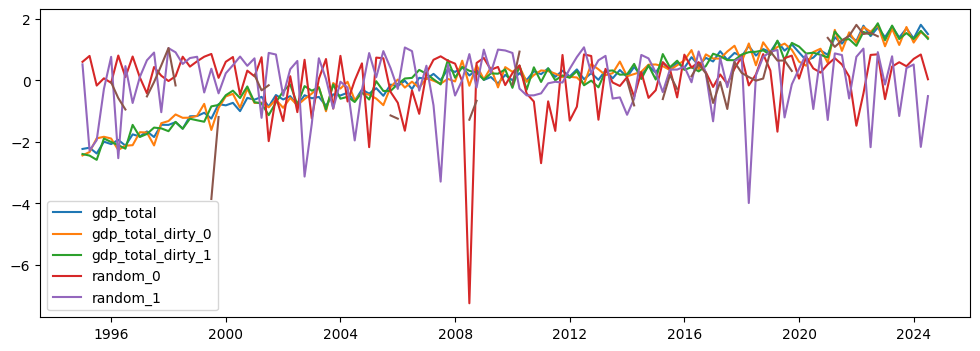

In [ ]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

print(scaled_features_df.shape)

In [3479]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [3480]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(119, 29)


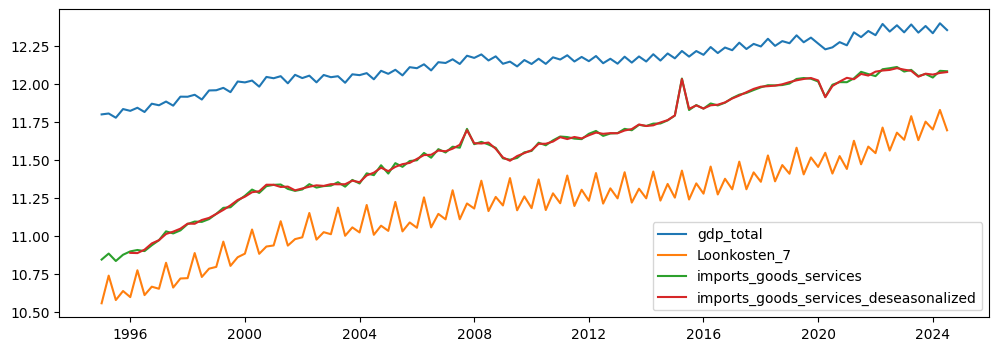

In [3481]:
df1[['gdp_total', 'Loonkosten_7', 'imports_goods_services', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [3482]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.05):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [3483]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.05):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

[ 7  8 14 16 22 23 24]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'exports_goods_services_deseasonalized', 'Loonkosten_7', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


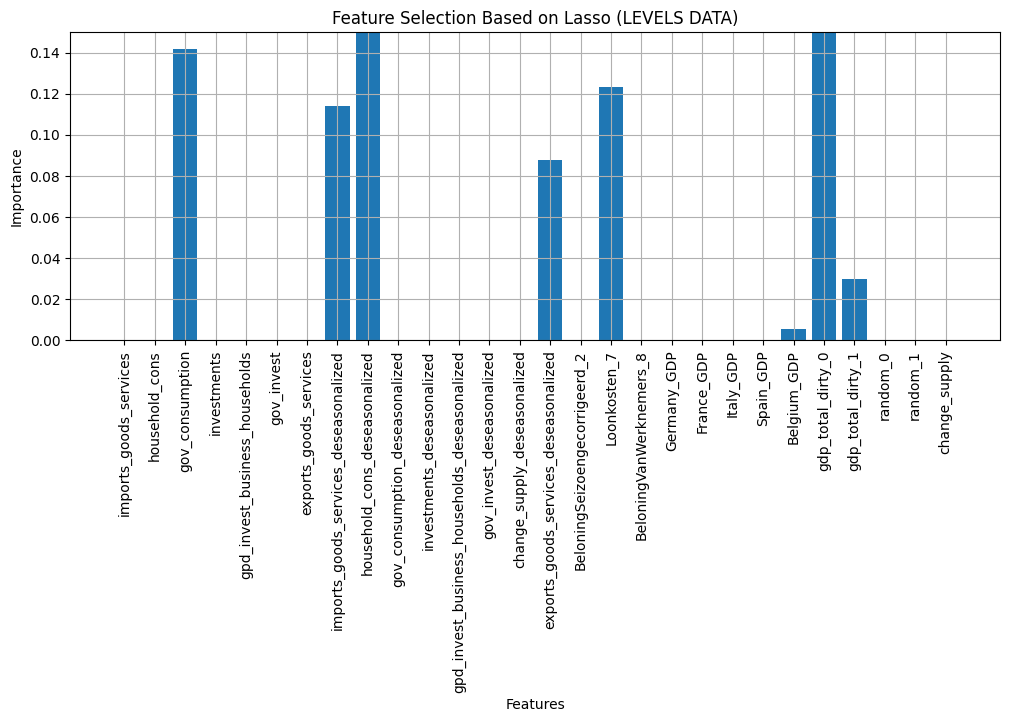

(119, 29)


In [3484]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 1  2  3  6 10 13 16 17 20 22 23 24 25 26 27]
['household_cons', 'gov_consumption', 'investments', 'exports_goods_services', 'investments_deseasonalized', 'change_supply_deseasonalized', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Italy_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'change_supply']


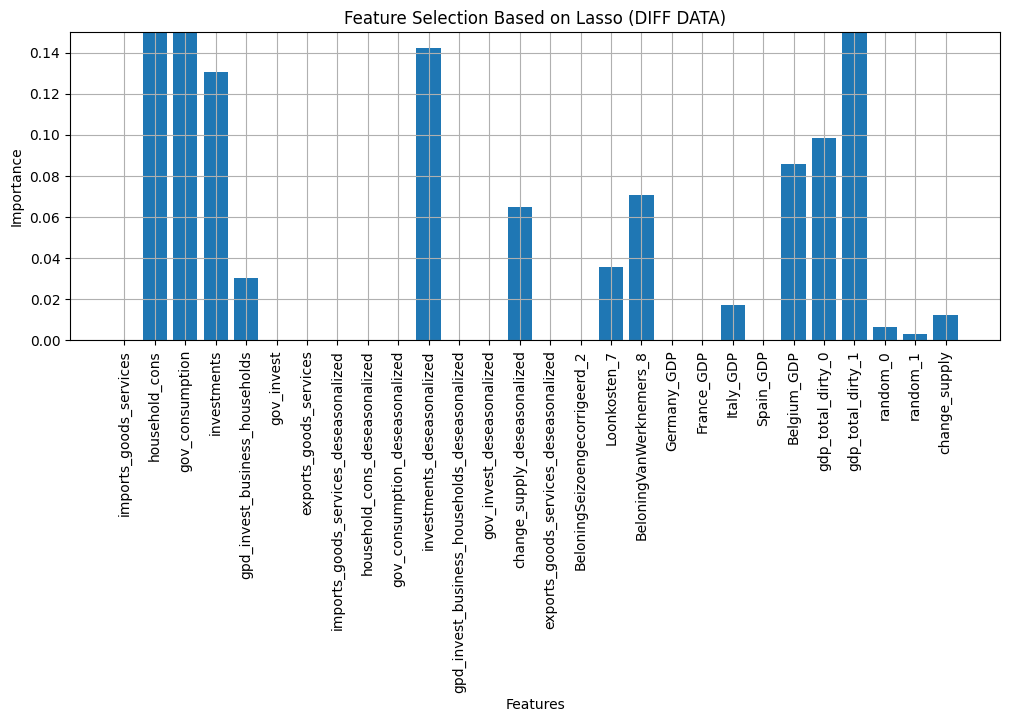

['household_cons',
 'gov_consumption',
 'investments',
 'exports_goods_services',
 'investments_deseasonalized',
 'change_supply_deseasonalized',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Italy_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'change_supply']

In [3485]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [3486]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(119, 34)


[ 0  1  2  6 11 13 17 19 20 22 23 30 32]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'household_cons_lag_1', 'exports_goods_services_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'BeloningSeizoengecorrigeerd_2_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'random_0_lag_1', 'change_supply_lag_1']


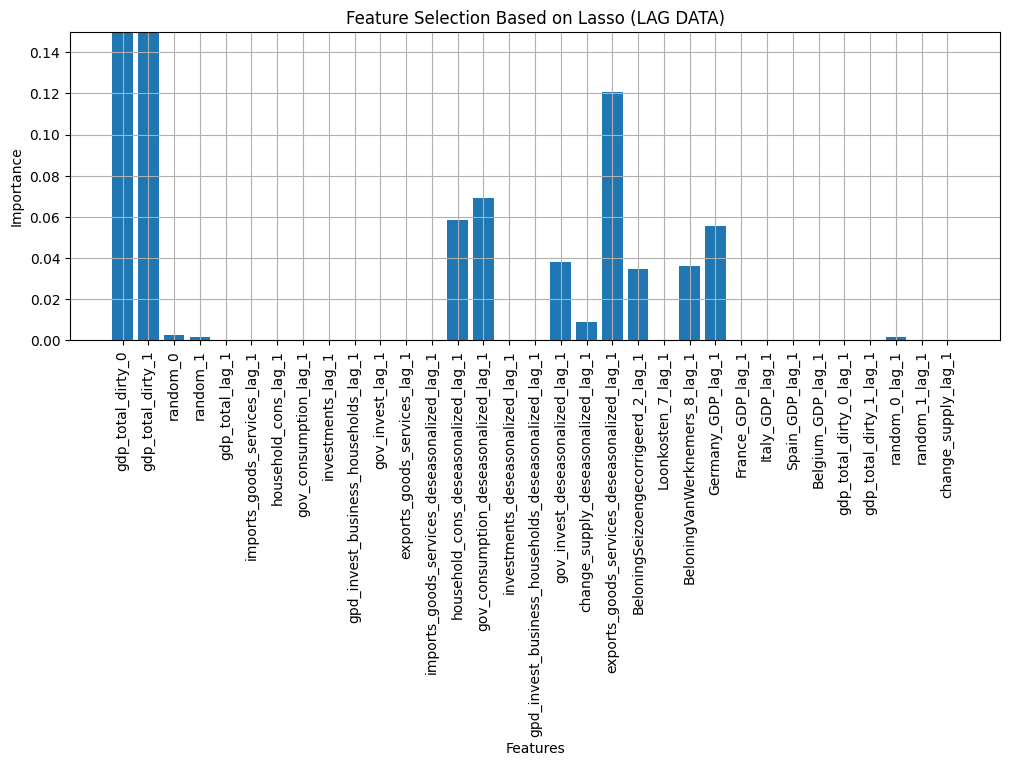

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'household_cons_lag_1',
 'exports_goods_services_lag_1',
 'household_cons_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'exports_goods_services_deseasonalized_lag_1',
 'BeloningSeizoengecorrigeerd_2_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'random_0_lag_1',
 'change_supply_lag_1']

In [3487]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  3  7  8 10 13 15 18 21 22 23 24 25 28 29 31 32]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1', 'gov_consumption_lag_1', 'investments_lag_1', 'gov_invest_lag_1', 'household_cons_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_1_lag_1', 'change_supply_lag_1']


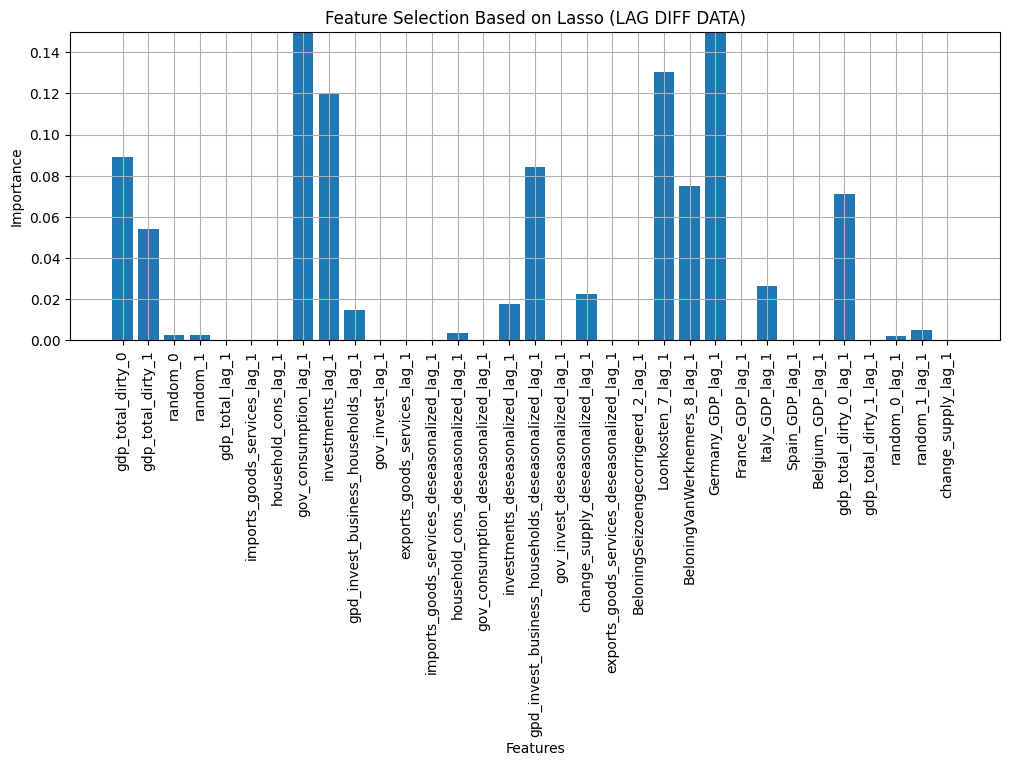

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1',
 'gov_consumption_lag_1',
 'investments_lag_1',
 'gov_invest_lag_1',
 'household_cons_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Loonkosten_7_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_1_lag_1',
 'change_supply_lag_1']

In [3488]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [3489]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [3490]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [3491]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(29, 3)


### If not stationary, difference, then test for stationarity again

In [3492]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

print(scaled_features_df_diff.shape)


(119, 29)


In [3493]:

form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')

<Axes: >

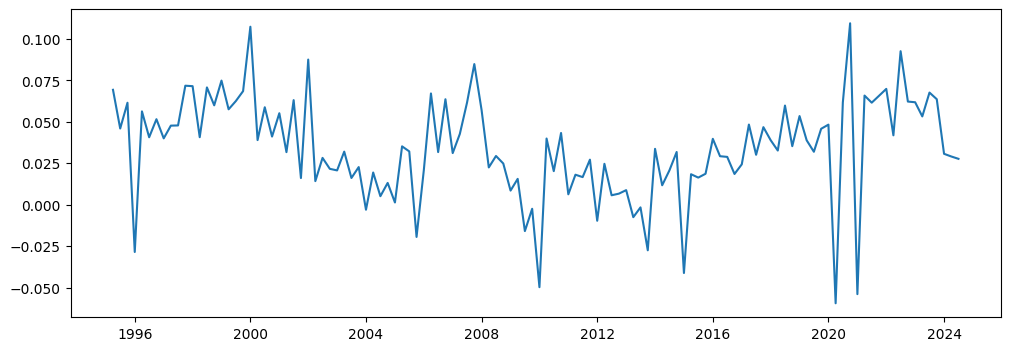

In [3494]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  3  6 10 13 16 17 20 22 23 24 27]
['household_cons', 'gov_consumption', 'investments', 'exports_goods_services', 'investments_deseasonalized', 'change_supply_deseasonalized', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Italy_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'change_supply']


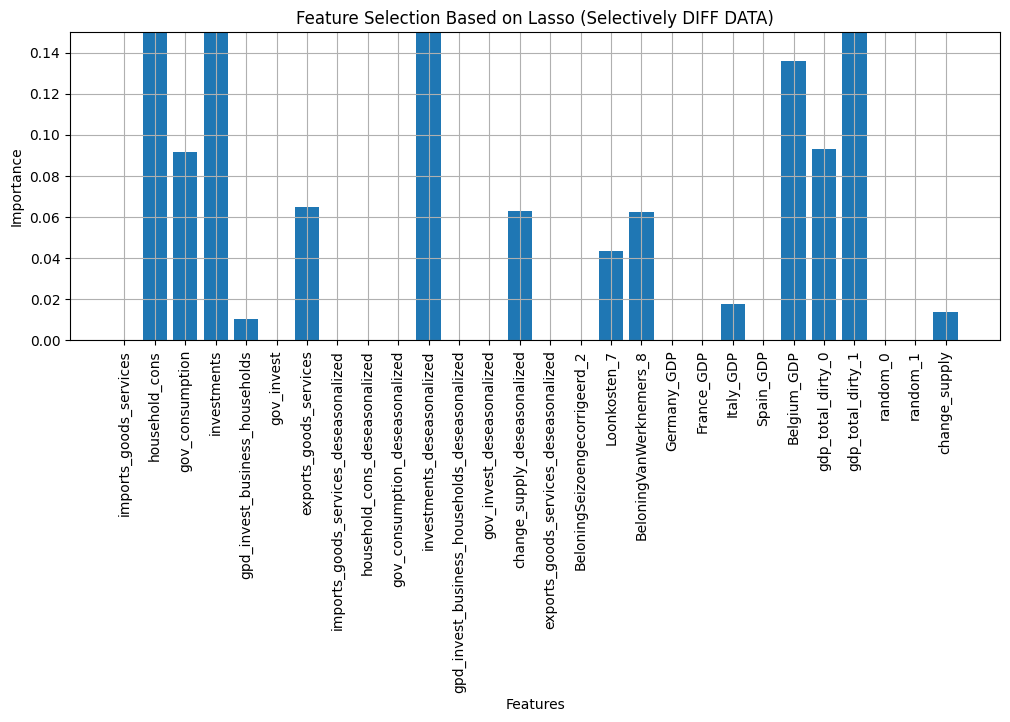

['household_cons',
 'gov_consumption',
 'investments',
 'exports_goods_services',
 'investments_deseasonalized',
 'change_supply_deseasonalized',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Italy_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'change_supply']

In [3495]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(119, 29)


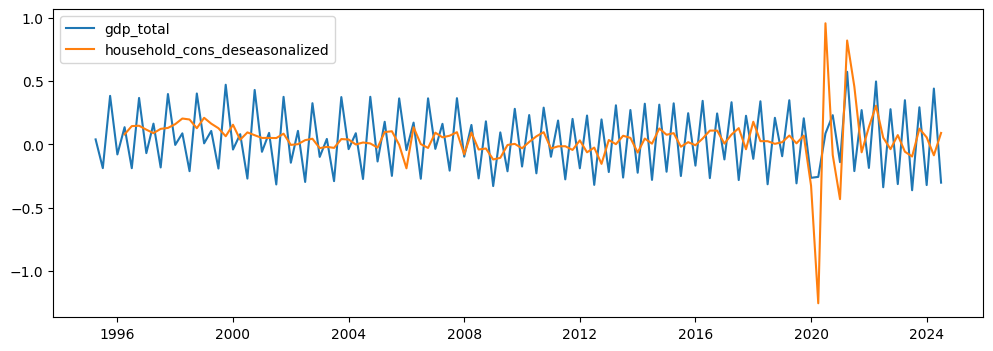

In [3496]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [3497]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(119, 58)


In [3498]:
scaled_features_df_diff_lag.columns

Index(['gdp_total', 'imports_goods_services', 'household_cons',
       'gov_consumption', 'investments', 'gpd_invest_business_households',
       'gov_invest', 'exports_goods_services',
       'imports_goods_services_deseasonalized',
       'household_cons_deseasonalized', 'gov_consumption_deseasonalized',
       'investments_deseasonalized',
       'gpd_invest_business_households_deseasonalized',
       'gov_invest_deseasonalized', 'change_supply_deseasonalized',
       'exports_goods_services_deseasonalized',
       'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7',
       'BeloningVanWerknemers_8', 'Germany_GDP', 'France_GDP', 'Italy_GDP',
       'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1',
       'random_0', 'random_1', 'change_supply', 'gdp_total_lag_1',
       'imports_goods_services_lag_1', 'household_cons_lag_1',
       'gov_consumption_lag_1', 'investments_lag_1',
       'gpd_invest_business_households_lag_1', 'gov_invest_lag_1',
       'exports_goods_se

In [3499]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

print(scaled_features_df_diff_lag_subset.shape)

(119, 30)


In [3500]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(119, 26)


In [3501]:
scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,imports_goods_services_lag_1,household_cons_lag_1,gov_consumption_lag_1,investments_lag_1,gpd_invest_business_households_lag_1,gov_invest_lag_1,exports_goods_services_lag_1,imports_goods_services_deseasonalized_lag_1,...,exports_goods_services_deseasonalized_lag_1,BeloningSeizoengecorrigeerd_2_lag_1,Loonkosten_7_lag_1,BeloningVanWerknemers_8_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,change_supply_lag_1
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-01,0.039939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-01,-0.187039,0.039939,0.110426,0.136152,0.295784,0.542601,0.479324,0.752257,-0.024277,NaN,...,NaN,0.069275,0.617169,NaN,0.093321,0.064942,NaN,0.410922,0.241957,-0.913175
1995-10-01,0.383544,-0.187039,-0.136567,0.109773,-0.495838,-0.922304,-0.909496,-0.545566,-0.141612,NaN,...,NaN,0.045931,-0.544940,NaN,0.159164,-0.311975,NaN,-0.235722,-0.234083,2.149208
1996-01-01,-0.078781,0.383544,0.114881,-0.233047,0.438177,1.181045,0.941423,1.925824,0.109035,NaN,...,NaN,0.061464,0.201614,NaN,0.152840,0.457994,NaN,0.481866,0.382766,0.470017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.361444,0.349390,0.031021,0.177570,0.433403,0.190677,0.182131,0.142540,0.063216,-0.023437,...,-0.048670,0.053226,0.526954,-0.014398,-0.215628,0.071169,0.438046,0.259744,0.294018,0.782242
2023-10-01,0.293252,-0.361444,-0.114809,-0.118885,-0.196531,-0.910391,-1.001209,0.134506,-0.122673,-0.114683,...,-0.076556,0.067605,-0.534625,-0.106199,0.142444,-0.158804,0.037557,-0.038561,-0.463612,-0.046442
2024-01-01,-0.320497,0.293252,0.039337,-0.136348,0.430602,0.319250,0.337295,0.066147,0.075325,0.059267,...,0.058422,0.063612,0.412720,0.031361,0.166604,0.437976,0.242919,0.283342,0.670086,0.784480
2024-04-01,0.441162,-0.320497,-0.065632,0.207147,-0.514130,0.152691,0.253751,-0.591951,-0.132835,-0.017790,...,-0.037040,0.030679,-0.174629,-0.009059,-0.121806,-0.212699,-0.711023,-0.295403,-0.449814,-1.932105


[ 3  4  5  6  9 10 11 14 17 18 19 20 21]
['gov_consumption_lag_1', 'investments_lag_1', 'gpd_invest_business_households_lag_1', 'gov_invest_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_consumption_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1']


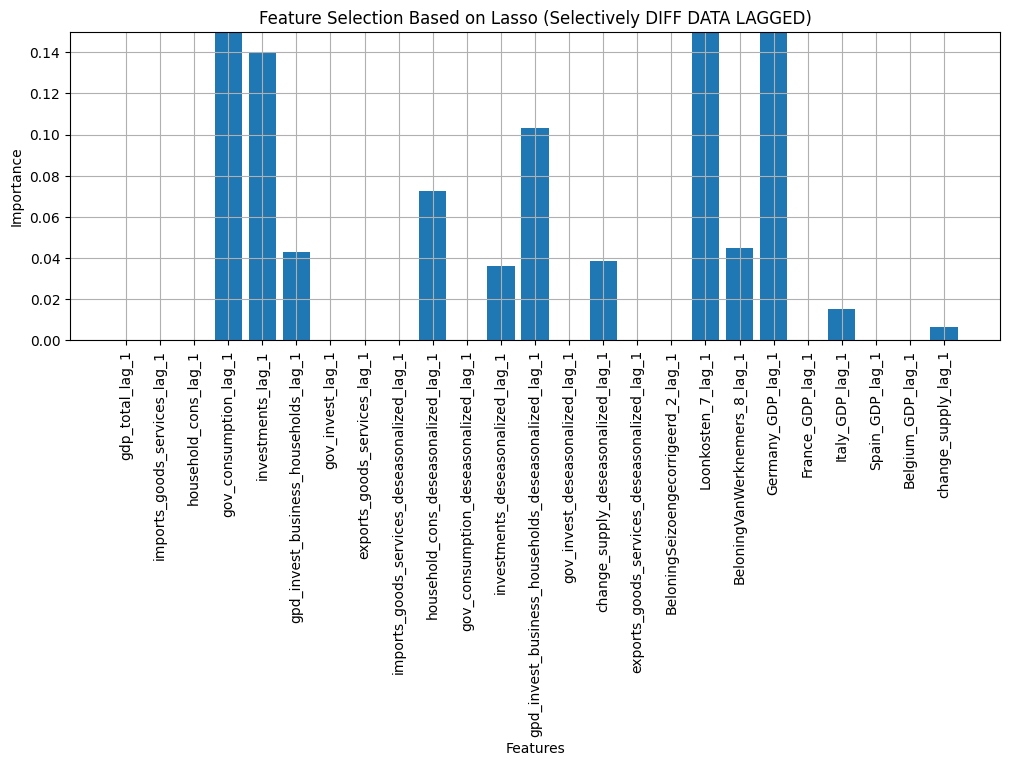

['gov_consumption_lag_1',
 'investments_lag_1',
 'gpd_invest_business_households_lag_1',
 'gov_invest_lag_1',
 'household_cons_deseasonalized_lag_1',
 'gov_consumption_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Loonkosten_7_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1']

In [3502]:
lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [3503]:
reg1 = scaled_features_df_diff_lag[['gdp_total', 'gov_consumption_lag_1', 'investments_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1']]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

import statsmodels.api as sm

test_train_split = 116

X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     121.7
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.74e-18
Time:                        08:47:40   Log-Likelihood:                 46.974
No. Observations:                  36   AIC:                            -83.95
Df Residuals:                      31   BIC:                            -76.03
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,exports_goods_services,imports_goods_services_deseasonalized,household_cons_deseasonalized,...,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1,change_supply_lag_1
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-01,0.039939,0.110426,0.136152,0.295784,0.542601,0.479324,0.752257,-0.024277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605804,0.523376,NaN
1995-07-01,-0.187039,-0.136567,0.109773,-0.495838,-0.922304,-0.909496,-0.545566,-0.141612,NaN,NaN,...,0.093321,0.064942,NaN,0.410922,0.241957,0.112325,-0.050656,0.798523,-2.278411,-0.913175
1995-10-01,0.383544,0.114881,-0.233047,0.438177,1.181045,0.941423,1.925824,0.109035,NaN,NaN,...,0.159164,-0.311975,NaN,-0.235722,-0.234083,0.443142,-0.138206,-0.165736,-1.940870,2.149208
1996-01-01,-0.078781,0.061871,0.492064,-0.343033,-0.804665,-0.495093,-2.250641,0.181717,NaN,NaN,...,0.152840,0.457994,NaN,0.481866,0.382766,0.051826,0.693462,0.069950,-0.275678,0.470017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.361444,-0.114809,-0.118885,-0.196531,-0.910391,-1.001209,0.134506,-0.122673,-0.114683,-0.094980,...,-0.215628,0.071169,0.438046,0.259744,0.294018,0.570327,0.475763,0.452041,0.786867,0.782242
2023-10-01,0.293252,0.039337,-0.136348,0.430602,0.319250,0.337295,0.066147,0.075325,0.059267,0.124658,...,0.142444,-0.158804,0.037557,-0.038561,-0.463612,-0.527930,-0.438364,0.593086,-1.155704,-0.046442
2024-01-01,-0.320497,-0.065632,0.207147,-0.514130,0.152691,0.253751,-0.591951,-0.132835,-0.017790,0.056044,...,0.166604,0.437976,0.242919,0.283342,0.670086,0.583617,0.196199,0.462382,0.402744,0.784480
2024-04-01,0.441162,0.123445,0.039661,0.480721,0.308115,0.239359,0.614620,0.192493,0.032118,-0.085612,...,-0.121806,-0.212699,-0.711023,-0.295403,-0.449814,-0.505487,-0.195197,0.701383,0.519105,-1.932105


<Axes: >

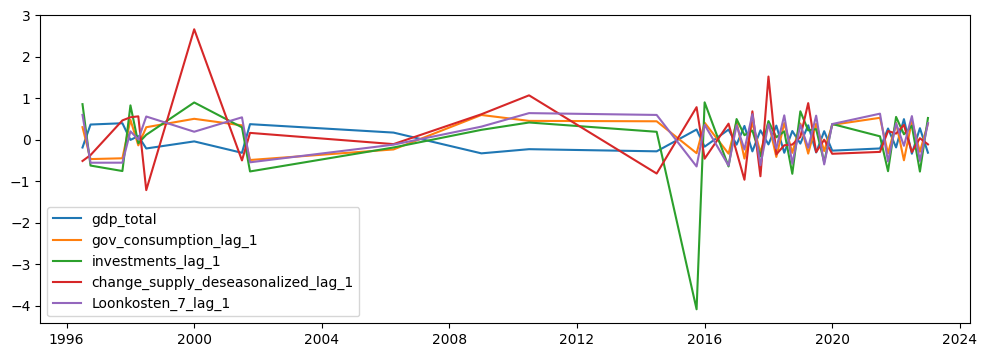

In [3504]:
reg1.plot()

In [3505]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1

In [3506]:

ynewpred = results.predict(Xnew)  # predict out of sample
print(ynewpred)

Series([], dtype: float64)


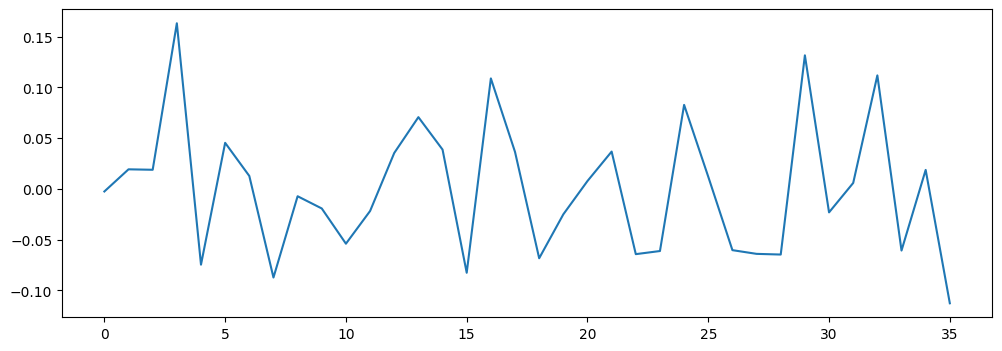

In [3507]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

In [3508]:
# results.resid[results.resid < -0.4] = np.mean(results.resid)

### Homoskedasticty

In [3509]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.05:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Homoskedasticity (Breusch-Pagan)


In [3510]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.05:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Homoskedasticity (White)


### Collinearity

In [3511]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

2.3111694176953956
Negative autoceorrelation is significant


### Normality

Residuals are normally distributed


(array([11.,  7., 12.,  2.,  4.]),
 array([-0.11280215, -0.05761435, -0.00242654,  0.05276126,  0.10794906,
         0.16313687]),
 <BarContainer object of 5 artists>)

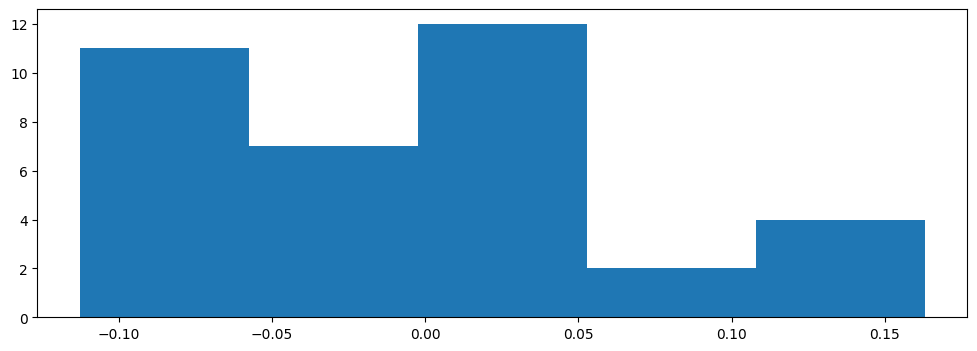

In [3512]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=5)